# 2.2 Analyses of combined states - state statistics

In [2]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd
import pickle

from one.api import ONE
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import  define_trial_types, rescale_sequence
from plotting_functions import plot_binned_sequence
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
one = ONE(mode='remote')

## Parameters

In [3]:
# Parameters
bin_size = 0.017
num_states = 2
threshold = 0
optimal_k = 4

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

path_sets = [wavelet_states_path, states_path, states_path]


# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


## Statistics per state

In [5]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type03-11-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [6]:

whisker_mapping = {0:'0', 1:'0', 2:'0', 3:'0',
                 4:'0', 5:'0', 6:'0', 7:'0',
                 8:'1', 9:'1', 10:'1', 11:'1',
                 12:'1', 13:'1', 14:'1', 15:'1'}

replace_whisker = np.vectorize(whisker_mapping.get)
states_file['most_likely_states'] = replace_whisker(states_file['most_likely_states'])
states_file = states_file.rename(columns={"variable": "Frequency"})
states_file = states_file.rename(columns={"most_likely_states": "Licking"})

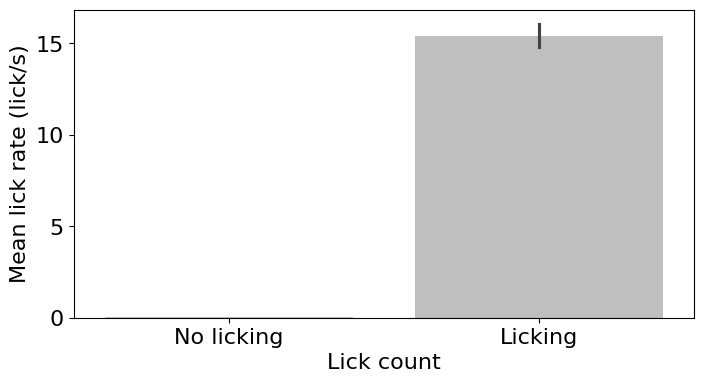

In [13]:
plt.figure(figsize=(8, 4))
# colors = sns.color_palette("viridis", 4)
grouped_df = pd.DataFrame(states_file.groupby(['session', 'Licking'])['Lick count'].mean()).reset_index()
grouped_df['Lick count'] = grouped_df['Lick count'] *60
sns.barplot(x='Licking', y='Lick count', data=grouped_df, color='grey',alpha=0.5)
plt.xlabel('Lick count')
plt.xticks([0, 1], ['No licking', 'Licking'])
plt.ylabel('Mean lick rate (lick/s)')


plt.rcParams.update({'font.size': 16})
# plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:

""" 
IMPORTS
"""
import os
import autograd.numpy as np
import pickle
import seaborn as sns
from collections import defaultdict
import pandas as pd
from matplotlib import colors as mcolors
from one.api import ONE
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import collections

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import concatenate_sessions, fix_discontinuities
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//3_postprocess_results/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability, transition_probabilities, trans_mat_complete
from plotting_functions import plot_states_aligned, align_bin_design_matrix, states_per_trial_phase, traces_over_few_sates

# one = ONE(base_url='https://alyx.internationalbrainlab.org')
one = ONE(mode='remote')

## Parameters

In [ ]:
bin_size = 0.1
multiplier = 1/bin_size

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

num_train_batches = 5
threshold = 0.05
sticky = False

# Values for grid search (should get this from results)
last_lag = 20
lag_step = 2
start_lag = 1
Lags = list(range(start_lag, last_lag, lag_step))
kappas = [0, 1, 5, 10, 100, 500, 1000, 2000, 5000, 7000, 10000]


## Get data

In [ ]:
# Load preprocessed data
prepro_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'
os.chdir(prepro_results_path)
idxs, mouse_names, matrix_all, matrix_all_unnorm, session_all = pickle.load(open(prepro_results_path + "preprocessed_data_v4_170724", "rb"))
collapsed_matrices, collapsed_unnorm, collapsed_trials = concatenate_sessions (mouse_names, matrix_all, matrix_all_unnorm, session_all)

## Plot combined states per animal

In [ ]:
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y'], ['nose_X', 'nose_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me'],
            ['left_X', 'left_Y', 'right_X', 'right_Y']]
use_sets = [['avg_wheel_vel'], ['Lick count'], ['whisker_me']]
var_interest_map = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'left_X', 'nose_X']
idx_init_list = [0, 1, 2, 3, 7]
idx_end_list = [1, 2, 3, 7, 9]

## Plot concatenated sessions

In [ ]:
# Loop through animals

for m, mouse_name in enumerate(np.unique(mouse_names)):
    
    try:
        # mouse_name = 'CSHL051'
        var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']
        
        # Get mouse data
        session_trials = collapsed_trials[mouse_name].copy()
        design_matrix = collapsed_matrices[mouse_name][:,0:3].copy()  # TODO: find a way for this not to be hardcoded
        unnorm_mat = collapsed_unnorm[mouse_name][var_names].copy()
        unnorm_mat['Bin'] = collapsed_unnorm[mouse_name]['Bin'].copy()
            
        # Get states per variable and concatenate
        states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
        os.chdir(states_path)

        c_states = []
        for s, set in enumerate(use_sets):
            
            most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name, "rb"))
            # Save
            if len(c_states) == 0:
                c_states = most_likely_states
            else:
                c_states = np.vstack((c_states, most_likely_states))      
        
        combined_states = remove_states_str(c_states.T, threshold)
            
        # Change states back to integer
        state_labels = np.unique(combined_states)
        int_state = np.arange(0, len(state_labels), 1).astype(float)
        if state_labels[-1] == 'nan':
            int_state[-1] = np.nan
        # Define the mapping as a dictionary
        mapping = {unique: key for unique, key in zip(state_labels, int_state)}

        # Use np.vectorize to apply the mapping
        replace_func = np.vectorize(mapping.get)
        new_states = replace_func(combined_states)

        " Plots "
        # Prepare data 
        num_timesteps = np.shape(design_matrix)[0]
        num_states = len(np.unique(new_states))
        
        # Prepare data
        design_matrix_heading = pd.DataFrame(columns=var_names)
        design_matrix_heading[var_names] = design_matrix[0:len(new_states)]  # TODO: need to understand why number is the same and whether it depends on lag
        bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
        design_matrix_heading['Bin'] = bins
        design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
        # Fix discontinuities
        cont_trials, cont_design_matrix_heading = fix_discontinuities(session_trials, design_matrix_heading, multiplier)
        
        # Align bins
        init = -1 * multiplier
        end = 1.5 * multiplier
        empirical_data = align_bin_design_matrix(init, end, event_type_list, cont_trials, cont_design_matrix_heading, new_states, multiplier)


        # """ Stack trial states """
        # trial_init = 30  # First trial to plot
        # trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
        # plot_states_aligned_trial(trial_init, empirical_data, cont_trials, bin_size, trials_to_plot, num_states)

        # " Plot states stacked and aligned per trial type "
        # # event_type_name = ['Feedback time']
        # plot_states_aligned(init, end, empirical_data, event_type_name, bin_size)
        
        # """ Plot states per trial epoch """
        # colors = sns.color_palette("viridis", num_states)
        # states_trial = states_per_trial_phase(empirical_data, cont_trials, multiplier)
        # plt.figure(figsize=[7, 5])
        # sns.histplot(x='label', hue=0, data=states_trial, stat = 'percent',
        #                     multiple="stack", legend=True, palette='viridis', alpha=0.3)  # stat='frequency',
        # plt.xlabel('Trial phase')
        # plt.legend(loc='upper left', bbox_to_anchor=(1, -0.5))
        # plt.xticks(rotation=45)
        # plt.tight_layout()
        # plt.title(mouse_name)
        # plt.show()
        
        """ Plot raw traces over states """
        init = 250 * multiplier # First bin
        inter = 10 * multiplier
        traces_over_few_sates(init, inter, empirical_data, cont_trials, var_names, multiplier)
        # traces_over_sates(init, inter, empirical_data, cont_trials)
    
    except:
        print(mouse_name)

CSHL045
CSHL047
CSHL049
CSHL051
CSHL052
CSHL054
CSHL058
CSHL059
CSHL060
DY_008
DY_009
DY_013
DY_014
DY_016
DY_018
KS014
KS022
KS023
KS044
KS051
KS084
KS086
KS091
KS096
NR_0020
NYU-45
PL015
PL016
PL017
SWC_038
SWC_043
SWC_052
SWC_053
SWC_054
SWC_058
SWC_061
SWC_065
SWC_066
UCLA012
UCLA033
UCLA034
UCLA035
UCLA037
ZFM-01592
ZFM-01935
ZFM-01936
ZFM-02369
ZFM-02370
ZFM-02372
ZFM-02373
ZM_1898
ZM_2240
ZM_2241
ZM_2245
ZM_3003
ibl_witten_25
ibl_witten_26
ibl_witten_29


## Plot individual sessions

In [ ]:
exclude_sessions = ['f1db6257-85ef-4385-b415-2d078ec75df2',
'259927fd-7563-4b03-bc5d-17b4d0fa7a55',
'e49d8ee7-24b9-416a-9d04-9be33b655f40',
'6f6d2c8e-28be-49f4-ae4d-06be2d3148c1',
'193fe7a8-4eb5-4f3e-815a-0c45864ddd77',
'f8d5c8b0-b931-4151-b86c-c471e2e80e5d',
'ebc9392c-1ecb-4b4b-a545-4e3d70d23611',
'537677fe-1e24-4755-948c-fa4a4e8ecce5',
'a4747ac8-6a75-444f-b99b-696fff0243fd',
'7be8fec4-406b-4e74-8548-d2885dcc3d5e',
'a71175be-d1fd-47a3-aa93-b830ea3634a1',
'53738f95-bd08-4d9d-9133-483fdb19e8da',
'd901aff5-2250-467a-b4a1-0cb9729df9e2',
'7939711b-8b4d-4251-b698-b97c1eaa846e',
'510b1a50-825d-44ce-86f6-9678f5396e02',
'aad23144-0e52-4eac-80c5-c4ee2decb198',
'd839491f-55d8-4cbe-a298-7839208ba12b',
'72cb5550-43b4-4ef0-add5-e4adfdfb5e02']

In [ ]:
group_state_freq = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_state', 'freq', 'median_duration', 'mean_duration', 'trans_mat'])
group_trans_mat = pd.DataFrame(columns=['mouse_name', 'session', 'trans_mat'], index=range(len(idxs)))
state_empirical_mean = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_states', 'variable', 'value'])
states_trial_type = pd.DataFrame(columns=['mouse_name', 'session', 'correct', 'choice', 'contrast', 
                                          'reaction', 'response', 'elongation', 'most_likely_states', 'Bin', 'label'])
for m, mat in enumerate(idxs):
    if len(mat) > 35: 
        # try:
        mouse_name = mat[37:]
        session = mat[0:36]
        
        if session not in exclude_sessions:
            var_names = ['avg_wheel_vel', 'Lick count', 'whisker_me']

            # Get mouse data          
            session_trials = session_all[mouse_name][session]
            design_matrix = matrix_all[mouse_name][session][:,0:3]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            # Get states per variable and concatenate
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/most_likely_states/'
            os.chdir(states_path)

            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
            
            " Prepare data "
            num_timesteps = np.shape(design_matrix)[0]
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(combined_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            
            # Transform states into identifiable states
            identifiable_states = state_identifiability(combined_states, design_matrix_heading)
            
            # Change states back to integer
            state_labels = np.unique(identifiable_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}
            inverted_mapping = {v: k for k, v in mapping.items()}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(identifiable_states)
            num_states = len(np.unique(new_states))

            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)
            empirical_data['identifiable_states'] = identifiable_states
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            
            
            """ State statistics """
            state_freq = pd.DataFrame(columns=['mouse_name', 'session', 'identifiable_state', 'freq', 
                                               'median_duration', 'mean_duration'], index=range(num_states))    
            
            state_freq['mouse_name'] = mouse_name
            state_freq['session'] = session
            state_freq['identifiable_state'] = collections.Counter(identifiable_states).keys()
            state_freq['freq'] = np.array(list(collections.Counter(identifiable_states).values()))/ len(identifiable_states)
            
            # State for which we have the durations
            dif = np.diff(new_states)
            jump = np.where(dif != 0)
            jump_dif = np.diff(jump)
            median = np.nanmedian(jump_dif)

            state_names = new_states[jump][1:]
            inverted_mapping = {v: k for k, v in mapping.items()}
            unique_states = np.array(list(inverted_mapping.keys()))
            unique_states = unique_states[~np.isnan(unique_states)]
            state_label = np.array(list(mapping.keys()))

            for s, st in enumerate(unique_states):
                state_durations = jump_dif[0][np.where(state_names==st)]
                state_freq.loc[state_freq['identifiable_state']==state_label[s], 'median_duration'] = np.median(state_durations)/multiplier
                state_freq.loc[state_freq['identifiable_state']==state_label[s], 'mean_duration'] = np.mean(state_durations)/multiplier

            # Save to big df
            if len(group_state_freq) == 0:
                group_state_freq = state_freq.copy()
            else:
                group_state_freq = group_state_freq.append(state_freq)
            
            
            """ State transition matrix (empirical) """
            transition_matrix = transition_probabilities(new_states, unique_states)
            # plt.imshow(transition_matrix)
            # plt.xlabel('Current state')
            # plt.ylabel('Previous state')
            # plt.show()
            group_trans_mat['mouse_name'][m] = mouse_name
            group_trans_mat['session'][m] = session
            group_trans_mat['trans_mat'][m] = trans_mat_complete(mapping, state_label, unique_states, transition_matrix)
    
            """ Plot state empirical mean """
            use_vars = ['avg_wheel_vel', 'Lick count', 'whisker_me', 'identifiable_states']
            use_data = empirical_data[use_vars].copy()
            use_data['avg_wheel_vel'] = np.abs(use_data['avg_wheel_vel'])
            melted = pd.melt(use_data, id_vars=['identifiable_states'], value_vars=use_vars)
            session_mean = pd.DataFrame(melted.groupby(['identifiable_states',
                                                                    'variable'])['value'].mean())
            session_mean = session_mean.reset_index(level=[0, 1])
            session_mean['mouse_name'] = mouse_name
            session_mean['session'] = session
            
            # Save to big df
            if len(state_empirical_mean) == 0:
                state_empirical_mean = session_mean.copy()
            else:
                state_empirical_mean = state_empirical_mean.append(session_mean)
            
        else:
            print(session)


/tmp/ipykernel_11088/3028026232.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']


FileNotFoundError: [Errno 2] No such file or directory: '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/0.1/most_likely_states/'

Text(0, 0.5, 'Normalized empirical mean value')

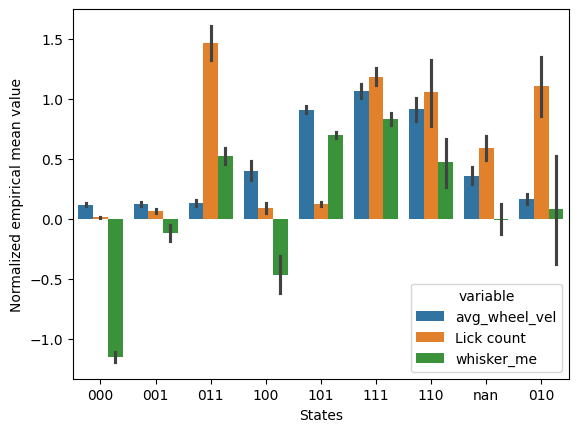

In [ ]:
sns.barplot(x='identifiable_states', y='value', hue='variable', hue_order=['avg_wheel_vel', 'Lick count', 'whisker_me'], data=state_empirical_mean)
plt.xlabel('States')
plt.ylabel('Normalized empirical mean value')


Text(79.22222222222221, 0.5, 'Previous state')

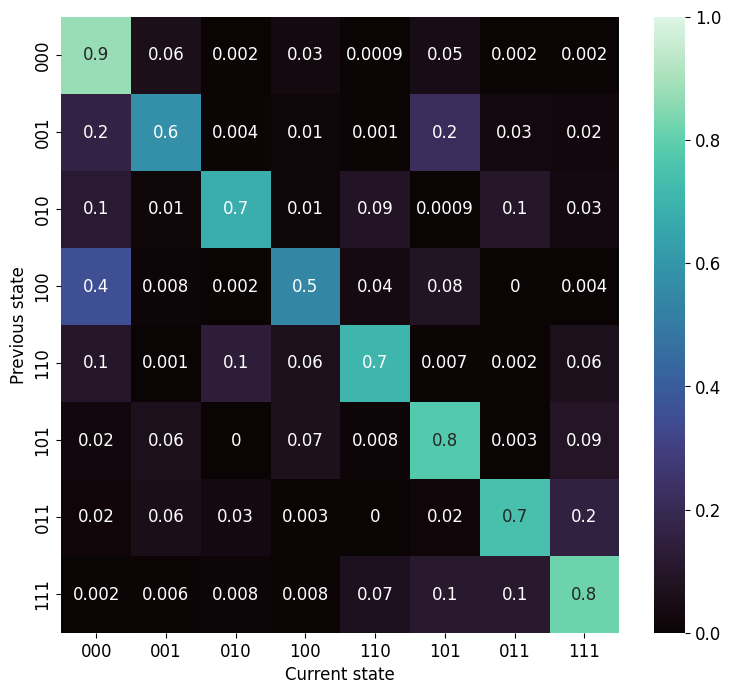

In [ ]:
labels = ['000', '001', '010', '100', '110', '101', '011', '111']

# Results on original model
plt.rc('font', size=12) 
plt.figure(figsize=[9, 8])
hmap = sns.color_palette("mako", as_cmap=True)
stacked_matrices = np.stack(group_trans_mat['trans_mat'].dropna().values)
nanmean_matrix = np.nanmean(stacked_matrices, axis=0)
sns.heatmap(nanmean_matrix, annot=True, fmt='.1g',
    yticklabels=labels, xticklabels=labels, 
    cmap= hmap, vmin=0, vmax=1) 
plt.xlabel('Current state')
plt.ylabel('Previous state')



In [ ]:
def trans_mat_complete(mapping, state_label, transition_matrix):
    states_template = ['000', '001', '010', '100', '110', '101', '011', '111']
    matrix_df = np.zeros((len(states_template), len(states_template))) * np.nan
    for r, row in enumerate(states_template):
        for c, column in enumerate(states_template):
            if (row in state_label) & (column in state_label):
                state_c = mapping[column]
                state_c_mat = np.where(unique_states==state_c)
                state_r = mapping[row]
                state_r_mat = np.where(unique_states==state_r)
                # if (state_c in unique_states) & (state_r in unique_states):
                matrix_df[r, c] = transition_matrix[state_r_mat, state_c_mat]
    
    return matrix_df

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 49.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 35.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 65.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 46.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/i

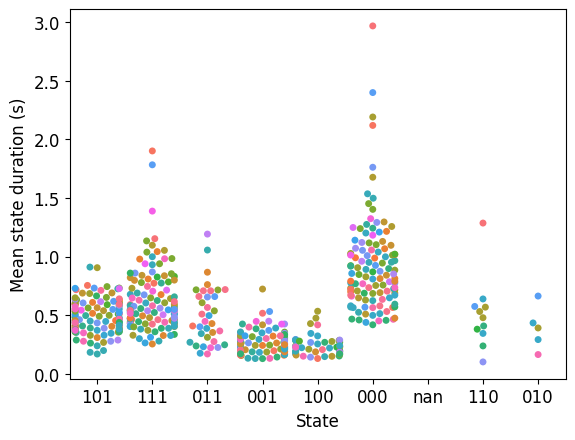

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 66.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 43.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 17.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 77.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/i

Text(38.347222222222214, 0.5, 'Median state duration (s)')

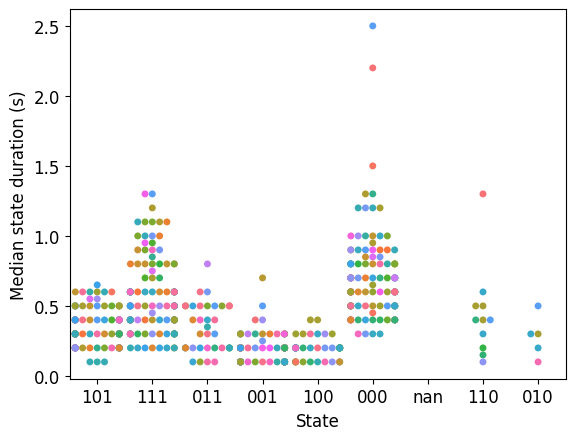

In [ ]:
sns.swarmplot(x='identifiable_state', y='mean_duration', hue='mouse_name', data=group_state_freq.reset_index(), legend=False)
plt.xlabel('State')
plt.ylabel('Mean state duration (s)')
plt.show()
sns.swarmplot(x='identifiable_state', y='median_duration', hue='mouse_name', data=group_state_freq.reset_index(), legend=False)
plt.xlabel('State')
plt.ylabel('Median state duration (s)')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 31.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 14.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/ines/miniconda3/envs/i

Text(38.347222222222214, 0.5, 'Frequency in session')

/home/ines/miniconda3/envs/iblenv/lib/python3.9/site-packages/seaborn/categorical.py:3399: UserWarning: 13.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


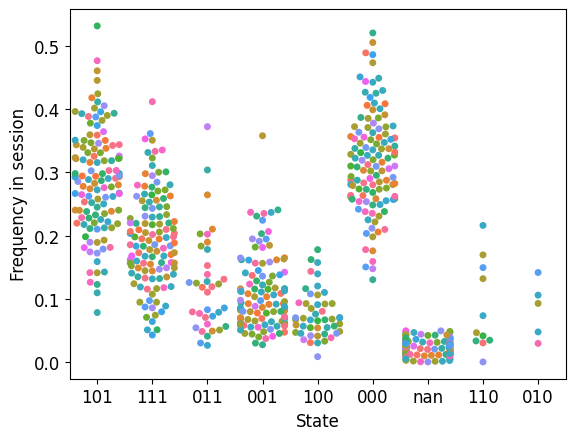

In [ ]:
sns.swarmplot(x='identifiable_state', y='freq', hue='mouse_name', data=group_state_freq, legend=False)
plt.xlabel('State')
plt.ylabel('Frequency in session')

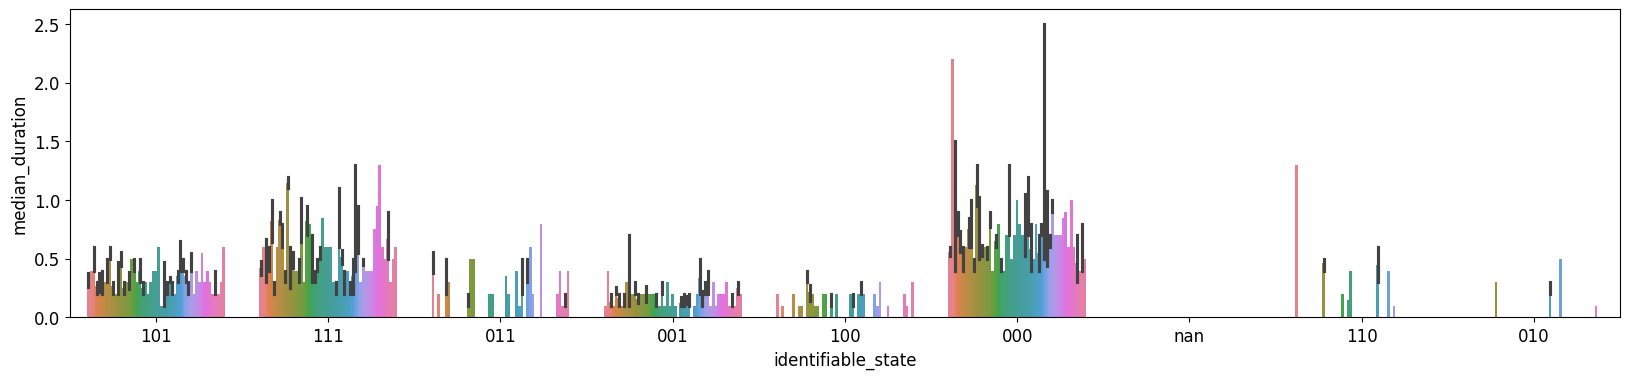

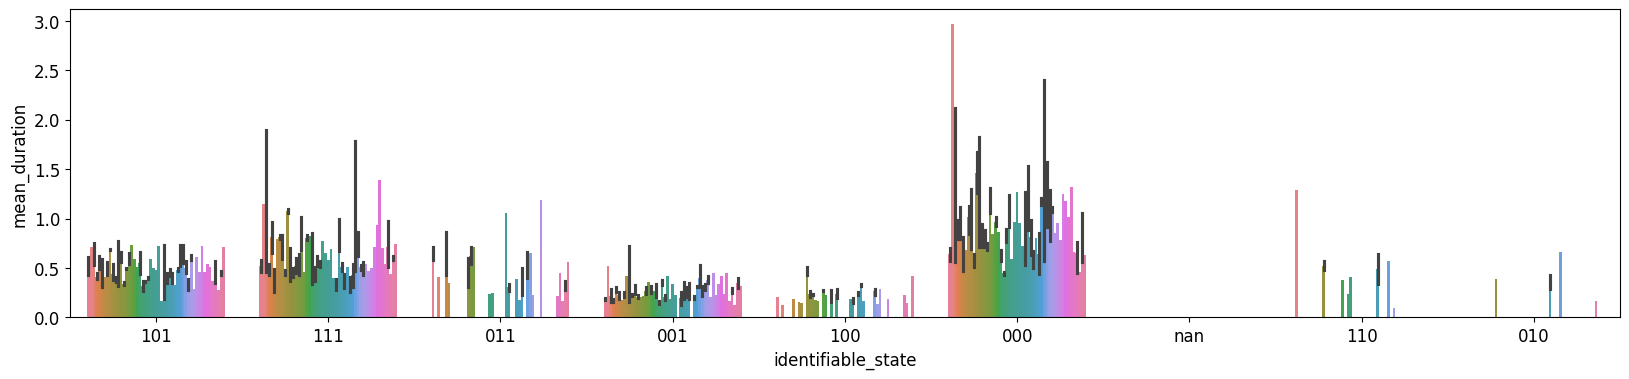

In [ ]:
plt.figure(figsize=[20, 4])
sns.barplot(x='identifiable_state', y='median_duration', hue='mouse_name', data=group_state_freq.reset_index(), legend=False)
plt.show()
plt.figure(figsize=[20, 4])
sns.barplot(x='identifiable_state', y='mean_duration', hue='mouse_name', data=group_state_freq.reset_index(), legend=False)
plt.show()

<AxesSubplot:xlabel='identifiable_state', ylabel='freq'>

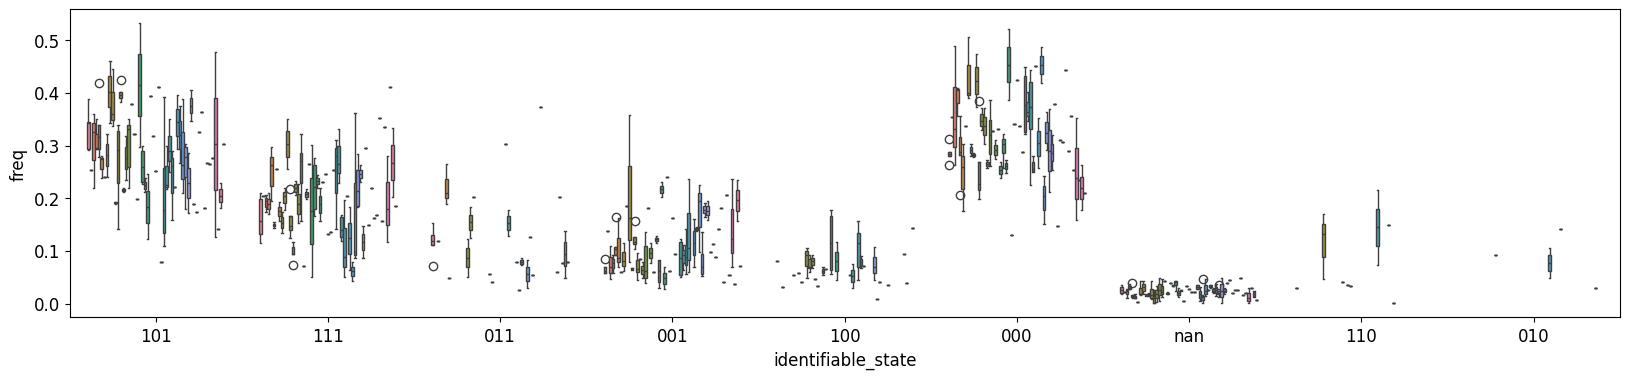

In [ ]:
plt.figure(figsize=[20, 4])
sns.boxplot(x='identifiable_state', y='freq', hue='mouse_name', data=group_state_freq, legend=False)

# Plot state statistics

In [ ]:
inverted_mapping = {v: k for k, v in mapping.items()}
unique_states = np.array(list(inverted_mapping.keys()))
unique_states = unique_states[~np.isnan(unique_states)]
state_label = np.array(list(mapping.keys()))

Text(0, 0.5, '# Occurences')

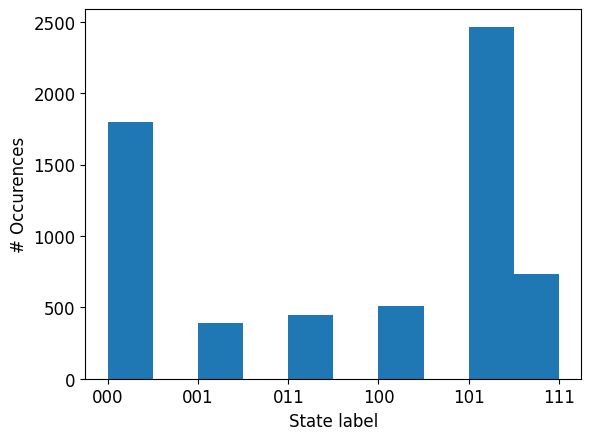

In [ ]:
""" State frequency """

plt.hist(new_states)
plt.xticks(np.arange(0, len(unique_states), 1), list(state_label[0:len(unique_states)]))
plt.xlabel('State label')
plt.ylabel('# Occurences')

In [ ]:
dif = np.diff(new_states)
jump = np.where(dif != 0)
jump_dif = np.diff(jump)
median = np.nanmedian(jump_dif)
print(median)

4.0


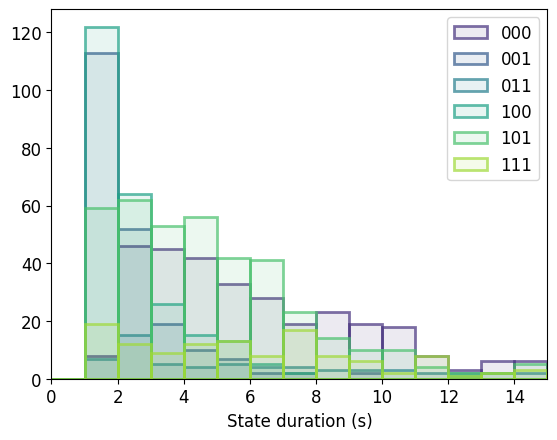

In [ ]:
""" State dwell time distribution """

# State for which we have the durations
state_names = new_states[jump][1:]

for s, st in enumerate(unique_states):
    
    state_durations = jump_dif[0][np.where(state_names==st)]
    col = sns.color_palette("viridis", len(unique_states))[int(st)]
    facecolor = mcolors.to_rgba(col,  .10)
    edgecolor = mcolors.to_rgba(col,  .70)
    style = {'facecolor': facecolor, 'edgecolor': edgecolor, 'linewidth': 2}  # 
    label = state_label[int(st)]
    bins = np.arange(0, 20, 1)
    plt.hist(state_durations, bins, label=label, **style)
    # plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/multiplier)
    plt.xlim([0, 15])
    plt.xlabel('State duration (s)')
plt.legend()


3.0


Text(0.5, 0, 'State duration (s)')

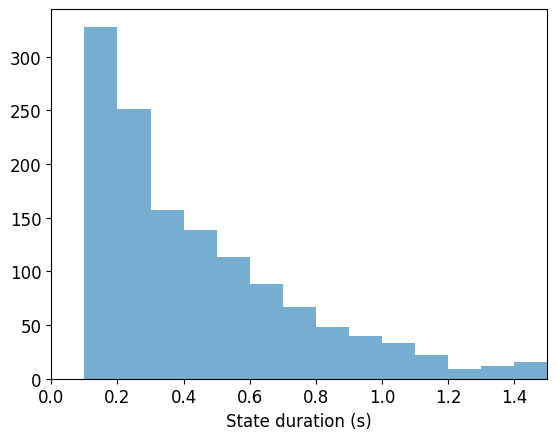

In [ ]:
""" State dwell time distribution """

dif = np.diff(new_states)
jump = np.where(dif != 0)
jump_dif = np.diff(jump)
median = np.nanmedian(jump_dif)
print(median)
bins = np.arange(0, 20, 1)
plt.hist(jump_dif[0], bins, alpha=0.6)
plt.xticks(np.arange(0, np.max(jump_dif[0]), 2), np.arange(0, np.max(jump_dif[0]), 2)/multiplier)
plt.xlim([0, 15])
plt.xlabel('State duration (s)')



In [ ]:
import plotly.express as px
fig = px.imshow(transition_matrix, text_auto=True)
fig.show()